In [2]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
from wordcloud import WordCloud
import nltk

from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split as tts

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score as acc

In [3]:
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

train.shape, test.shape

((31962, 3), (17197, 2))

In [3]:
trainSize = train.shape[0]

combi = train.append(test, ignore_index=True)

# Data Preprocessing

In [4]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

In [5]:
combi['clean'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") #removing users
combi['clean'] = combi['clean'].str.replace("[^a-zA-Z#]", " ") #obtaining only words and hashtags
combi['clean'] = combi['clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #removing shortwords

In [6]:
tokenized_tweet = combi['clean'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean, dtype: object

In [7]:
stopw = set(stopwords.words('english'))

for i in range(tokenized_tweet.shape[0]):
    tokenized_tweet[i] = [w for w in tokenized_tweet[i] if w not in stopw]

stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [father, dysfunct, selfish, drag, kid, dysfunc...
1    [thank, #lyft, credit, caus, offer, wheelchair...
2                                    [bihday, majesti]
3                           [#model, love, take, time]
4                         [factsguid, societi, #motiv]
Name: clean, dtype: object

In [8]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['clean'] = tokenized_tweet

# Visualization

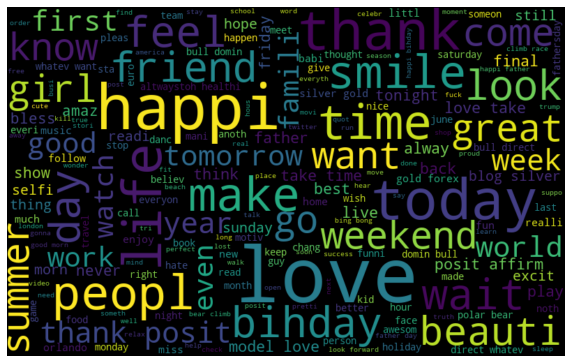

In [9]:
#for normal tweets
normal_words =' '.join([text for text in combi['clean'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

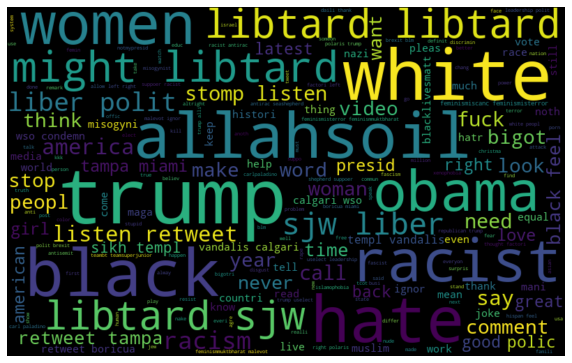

In [10]:
#hateful tweets
negative_words = ' '.join([text for text in combi['clean'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [12]:
HT_regular = hashtag_extract(combi['clean'][combi['label'] == 0])

HT_negative = hashtag_extract(combi['clean'][combi['label'] == 1])

HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

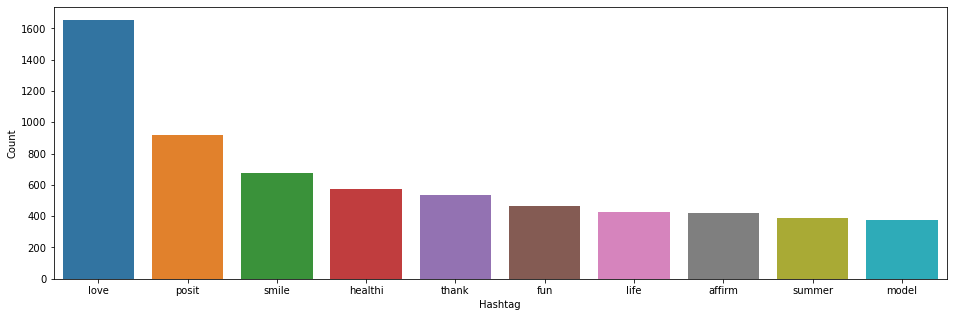

In [13]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
 
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

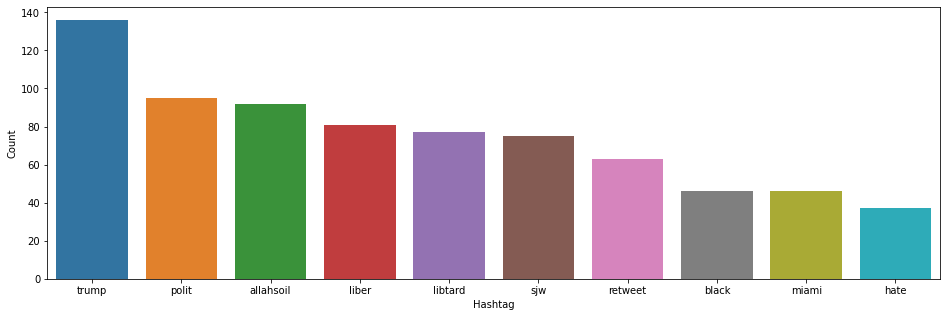

In [14]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# BOW + TFIDF 

In [15]:
tfidf_vectorizer = TfidfVectorizer()
bow_vectorizer = CountVectorizer()

In [16]:
bow = bow_vectorizer.fit_transform(combi['clean'])
tfidf = tfidf_vectorizer.fit_transform(combi['clean'])

In [17]:
lreg = LogisticRegression()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors = 15)
rf = RandomForestClassifier()
svc = SVC(kernel = 'rbf', probability = True)

models = [lreg, dt, knn, rf, svc]

In [18]:
def train_and_evaluate(trainx, trainy, testx, testy, models):
    
    f1S = []
    accS = []
   
    for i in models:
        i.fit(trainx, trainy)
        pred = i.predict_proba(testx)
        pred = pred[:,1] >= 0.3
        f1 = f1_score(testy, pred)
        ac = acc(testy, pred)
        f1S.append(f1), accS.append(ac)
    
    return f1S, accS

In [19]:
train_bow = bow[:trainSize,:]
test_bow = bow[trainSize:,:]

xtrain_bow, xvalid_bow, ytrain, yvalid = tts(train_bow, train['label'], random_state=42, test_size=0.3)

f1, ac = train_and_evaluate(xtrain_bow, ytrain, xvalid_bow, yvalid, models)

print(f1)
print(ac)

[0.6481178396072014, 0.5571929824561402, 0.23650385604113114, 0.6399427344309233, 0.6725099601593625]
[0.9551569506726457, 0.9341954322661383, 0.9380540202315153, 0.9475440609031182, 0.9571383877359474]


In [20]:
train_tfidf = tfidf[:trainSize,:]
test_tfidf = tfidf[trainSize:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

f1, ac = train_and_evaluate(xtrain_tfidf, ytrain, xvalid_tfidf, yvalid, models) 

print(f1)
print(ac)

[0.5630331753554503, 0.6016755521706018, 0.20653594771241826, 0.6714285714285715, 0.6825396825396826]
[0.9519240796746272, 0.94545833767859, 0.936698300135572, 0.9568255292522683, 0.9582855355094378]
